Let's see if we can replicate some results of 'extracting paragraphs'

This time we're using `deepseek-ai/DeepSeek-R1-Distill-Llama-8B`

In [8]:
import torch 
import math
from nnsight import CONFIG
import nnsight
import numpy as np 
import matplotlib.pyplot as plt
import os
from dotenv import load_dotenv
load_dotenv()

True

In [9]:
from activation_transplanting import *

Note: place ndif key and hf token in a file called .env 

eg:
```
HF_TOKEN="Token here"
NDIF_KEY="Key here"
```

In [10]:
# read the api_key
CONFIG.set_default_api_key(os.environ.get('NDIF_KEY'))

In [11]:
import os

# read the api_key

# Llama 3.1 8b is a gated model, so you need to apply for access on HuggingFace and include your token.
os.environ['HF_TOKEN'] = os.environ.get('HF_TOKEN')

## The Experiment 

Confirm the basic findings of `Extracting Paragraphs` 

Finding 1:
> Attention is focused around the `\n\n` tokens, after an instruction

Finding 2:
> By replacing the activations at newlines with another set of activations, we can make the model reproduce the original prompt 

In [12]:
from nnsight import LanguageModel
# We'll never actually load the parameters locally, so no need to specify a device_map.
llama = LanguageModel("deepseek-ai/DeepSeek-R1-Distill-Llama-8B")
# All we need to specify using NDIF vs executing locally is remote=True.

In [13]:
llama

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(128256, 4096)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear(in_features=4096, out_features=1024, bias=False)
          (v_proj): Linear(in_features=4096, out_features=1024, bias=False)
          (o_proj): Linear(in_features=4096, out_features=4096, bias=False)
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=4096, out_features=14336, bias=False)
          (up_proj): Linear(in_features=4096, out_features=14336, bias=False)
          (down_proj): Linear(in_features=14336, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm((4096,), eps=1e-05)
        (post_attention_layernorm): LlamaRMSNorm((4096,), eps=1e-05)
      )
    )
    (norm): LlamaRMSNorm((4096,), eps=1e-05)
    (rotary_

TODO: get temperature in the config 

In [22]:
llama.tokenizer

LlamaTokenizerFast(name_or_path='deepseek-ai/DeepSeek-R1-Distill-Llama-8B', vocab_size=128000, model_max_length=16384, is_fast=True, padding_side='left', truncation_side='right', special_tokens={'bos_token': '<｜begin▁of▁sentence｜>', 'eos_token': '<｜end▁of▁sentence｜>', 'pad_token': '<｜end▁of▁sentence｜>'}, clean_up_tokenization_spaces=False, added_tokens_decoder={
	128000: AddedToken("<｜begin▁of▁sentence｜>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	128001: AddedToken("<｜end▁of▁sentence｜>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	128002: AddedToken("<|reserved_special_token_0|>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	128003: AddedToken("<|reserved_special_token_1|>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	128004: AddedToken("<|finetune_right_pad_id|>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=T

In [15]:
num_examples = 1 # how many examples to use in the context?

with open("context.txt", 'r') as file:
    context = file.read()

context = "\n--\n".join(context.split("\n--\n")[:num_examples])+"\n--\n"

In [16]:
print(context)

What are the key elements of photosynthesis?

Photosynthesis is the process where plants convert sunlight, water, and carbon dioxide into glucose and oxygen. It occurs in chloroplasts containing chlorophyll, which captures light energy. The process includes light-dependent reactions producing ATP and NADPH, and the Calvin cycle that uses these to fix carbon dioxide into sugar.
--



In [17]:
s1 = "What was the cause of the Punic War?\n\n"
s2 = "What were the causes of the Civil War?\n\n"


In [18]:
print(context+s1)

What are the key elements of photosynthesis?

Photosynthesis is the process where plants convert sunlight, water, and carbon dioxide into glucose and oxygen. It occurs in chloroplasts containing chlorophyll, which captures light energy. The process includes light-dependent reactions producing ATP and NADPH, and the Calvin cycle that uses these to fix carbon dioxide into sugar.
--
What was the cause of the Punic War?




In [23]:
[llama.tokenizer.decode(k) for k in llama.tokenizer.encode("User: write me a poem. Assistant:")]

['<｜begin▁of▁sentence｜>',
 'User',
 ':',
 ' write',
 ' me',
 ' a',
 ' poem',
 '.',
 ' Assistant',
 ':']

In [24]:
with llama.generate(
            "User: write me a poem. Assistant:",
            max_new_tokens=20,
            remote=True,
        ) as tracer:
    out = llama.generator.output.save()


2025-03-08 15:33:06,058 4d123cc1-9476-4fd5-bd19-7012fe86fbe4 - RECEIVED: Your job has been received and is waiting approval.
2025-03-08 15:33:07,328 4d123cc1-9476-4fd5-bd19-7012fe86fbe4 - APPROVED: Your job was approved and is waiting to be run.
2025-03-08 15:33:07,644 4d123cc1-9476-4fd5-bd19-7012fe86fbe4 - RUNNING: Your job has started running.
2025-03-08 15:33:15,532 4d123cc1-9476-4fd5-bd19-7012fe86fbe4 - COMPLETED: Your job has been completed.


In [27]:
llama.tokenizer

LlamaTokenizerFast(name_or_path='deepseek-ai/DeepSeek-R1-Distill-Llama-8B', vocab_size=128000, model_max_length=16384, is_fast=True, padding_side='left', truncation_side='right', special_tokens={'bos_token': '<｜begin▁of▁sentence｜>', 'eos_token': '<｜end▁of▁sentence｜>', 'pad_token': '<｜end▁of▁sentence｜>'}, clean_up_tokenization_spaces=False, added_tokens_decoder={
	128000: AddedToken("<｜begin▁of▁sentence｜>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	128001: AddedToken("<｜end▁of▁sentence｜>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	128002: AddedToken("<|reserved_special_token_0|>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	128003: AddedToken("<|reserved_special_token_1|>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	128004: AddedToken("<|finetune_right_pad_id|>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=T

In [26]:
print(llama.tokenizer.decode(out[0]))

<｜begin▁of▁sentence｜>User: write me a poem. Assistant: I'm not sure I can do that, but I can help you brainstorm ideas or write a short


In [46]:

llama.tokenizer.chat_template

"{% if not add_generation_prompt is defined %}{% set add_generation_prompt = false %}{% endif %}{% set ns = namespace(is_first=false, is_tool=false, is_output_first=true, system_prompt='') %}{%- for message in messages %}{%- if message['role'] == 'system' %}{% set ns.system_prompt = message['content'] %}{%- endif %}{%- endfor %}{{bos_token}}{{ns.system_prompt}}{%- for message in messages %}{%- if message['role'] == 'user' %}{%- set ns.is_tool = false -%}{{'<｜User｜>' + message['content']}}{%- endif %}{%- if message['role'] == 'assistant' and message['content'] is none %}{%- set ns.is_tool = false -%}{%- for tool in message['tool_calls']%}{%- if not ns.is_first %}{{'<｜Assistant｜><｜tool▁calls▁begin｜><｜tool▁call▁begin｜>' + tool['type'] + '<｜tool▁sep｜>' + tool['function']['name'] + '\\n' + '```json' + '\\n' + tool['function']['arguments'] + '\\n' + '```' + '<｜tool▁call▁end｜>'}}{%- set ns.is_first = true -%}{%- else %}{{'\\n' + '<｜tool▁call▁begin｜>' + tool['type'] + '<｜tool▁sep｜>' + tool['fu

In [42]:
with llama.generate(
            "<｜User｜>Robert has three apples, and then gets one more. How many apples does he have? Respond in a single word.<｜Assistant｜>",
            max_new_tokens=200,
            remote=True,
        ) as tracer:
    out = llama.generator.output.save()

2025-03-08 16:24:27,924 dceb0c19-3c8c-40d5-87b9-ae7ad83b9a9a - RECEIVED: Your job has been received and is waiting approval.
2025-03-08 16:24:28,651 dceb0c19-3c8c-40d5-87b9-ae7ad83b9a9a - APPROVED: Your job was approved and is waiting to be run.
2025-03-08 16:24:29,294 dceb0c19-3c8c-40d5-87b9-ae7ad83b9a9a - RUNNING: Your job has started running.
2025-03-08 16:24:35,859 dceb0c19-3c8c-40d5-87b9-ae7ad83b9a9a - COMPLETED: Your job has been completed.


In [41]:
[llama.tokenizer.decode(k) for k in llama.tokenizer.encode("<｜User｜>Robert has three apples, and then gets one more. How many apples does he have? Respond using a single word.<｜Assistant｜>")]

['<｜begin▁of▁sentence｜>',
 '<｜User｜>',
 'Robert',
 ' has',
 ' three',
 ' apples',
 ',',
 ' and',
 ' then',
 ' gets',
 ' one',
 ' more',
 '.',
 ' How',
 ' many',
 ' apples',
 ' does',
 ' he',
 ' have',
 '?',
 ' Respond',
 ' using',
 ' a',
 ' single',
 ' word',
 '.',
 '<｜Assistant｜>']

In [43]:
print(llama.tokenizer.decode(out[0]))

<｜begin▁of▁sentence｜><｜User｜>Robert has three apples, and then gets one more. How many apples does he have? Respond in a single word.<｜Assistant｜><think>
He starts with three apples. After receiving one more, the total number of apples becomes four.
</think>

He starts with **3** apples.

After receiving **1** more apple, the total number of apples becomes:

\[
3 + 1 = 4
\]

**Answer:** \boxed{4}<｜end▁of▁sentence｜>


In [19]:
# commented out for now

tk = LLamaExamineToolkit(
    llama_model=llama, 
    remote=True, # use NDIF
    num_prev=1 # Take one additional token backwards in time -- not only the ?/n/n token, but one extra
)

2025-03-08 14:43:31,986 7efedba4-fb02-4f8c-80f7-875f94807c39 - RECEIVED: Your job has been received and is waiting approval.
2025-03-08 14:43:32,438 7efedba4-fb02-4f8c-80f7-875f94807c39 - APPROVED: Your job was approved and is waiting to be run.
2025-03-08 14:43:34,333 7efedba4-fb02-4f8c-80f7-875f94807c39 - RUNNING: Your job has started running.
2025-03-08 14:43:36,891 7efedba4-fb02-4f8c-80f7-875f94807c39 - COMPLETED: Your job has been completed.
c:\Users\durrc\OneDrive\Desktop\mech_interp_work\mech_interp_research\activation_transplanting.py:435: UserWarning: Glyph 65372 (\N{FULLWIDTH VERTICAL LINE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()  # Adjusts spacing so x and y labels don't overlap the figure edges
c:\Users\durrc\OneDrive\Desktop\mech_interp_work\mech_interp_research\activation_transplanting.py:440: UserWarning: Glyph 65372 (\N{FULLWIDTH VERTICAL LINE}) missing from font(s) DejaVu Sans.
  plt.savefig(outpath, bbox_inches="tight")
c:\Users\durrc\OneDrive\Desktop\

KeyboardInterrupt: 

c:\Users\durrc\OneDrive\Desktop\mech_interp_work\venv\Lib\site-packages\IPython\core\events.py:82: UserWarning: Glyph 65372 (\N{FULLWIDTH VERTICAL LINE}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
c:\Users\durrc\OneDrive\Desktop\mech_interp_work\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 65372 (\N{FULLWIDTH VERTICAL LINE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


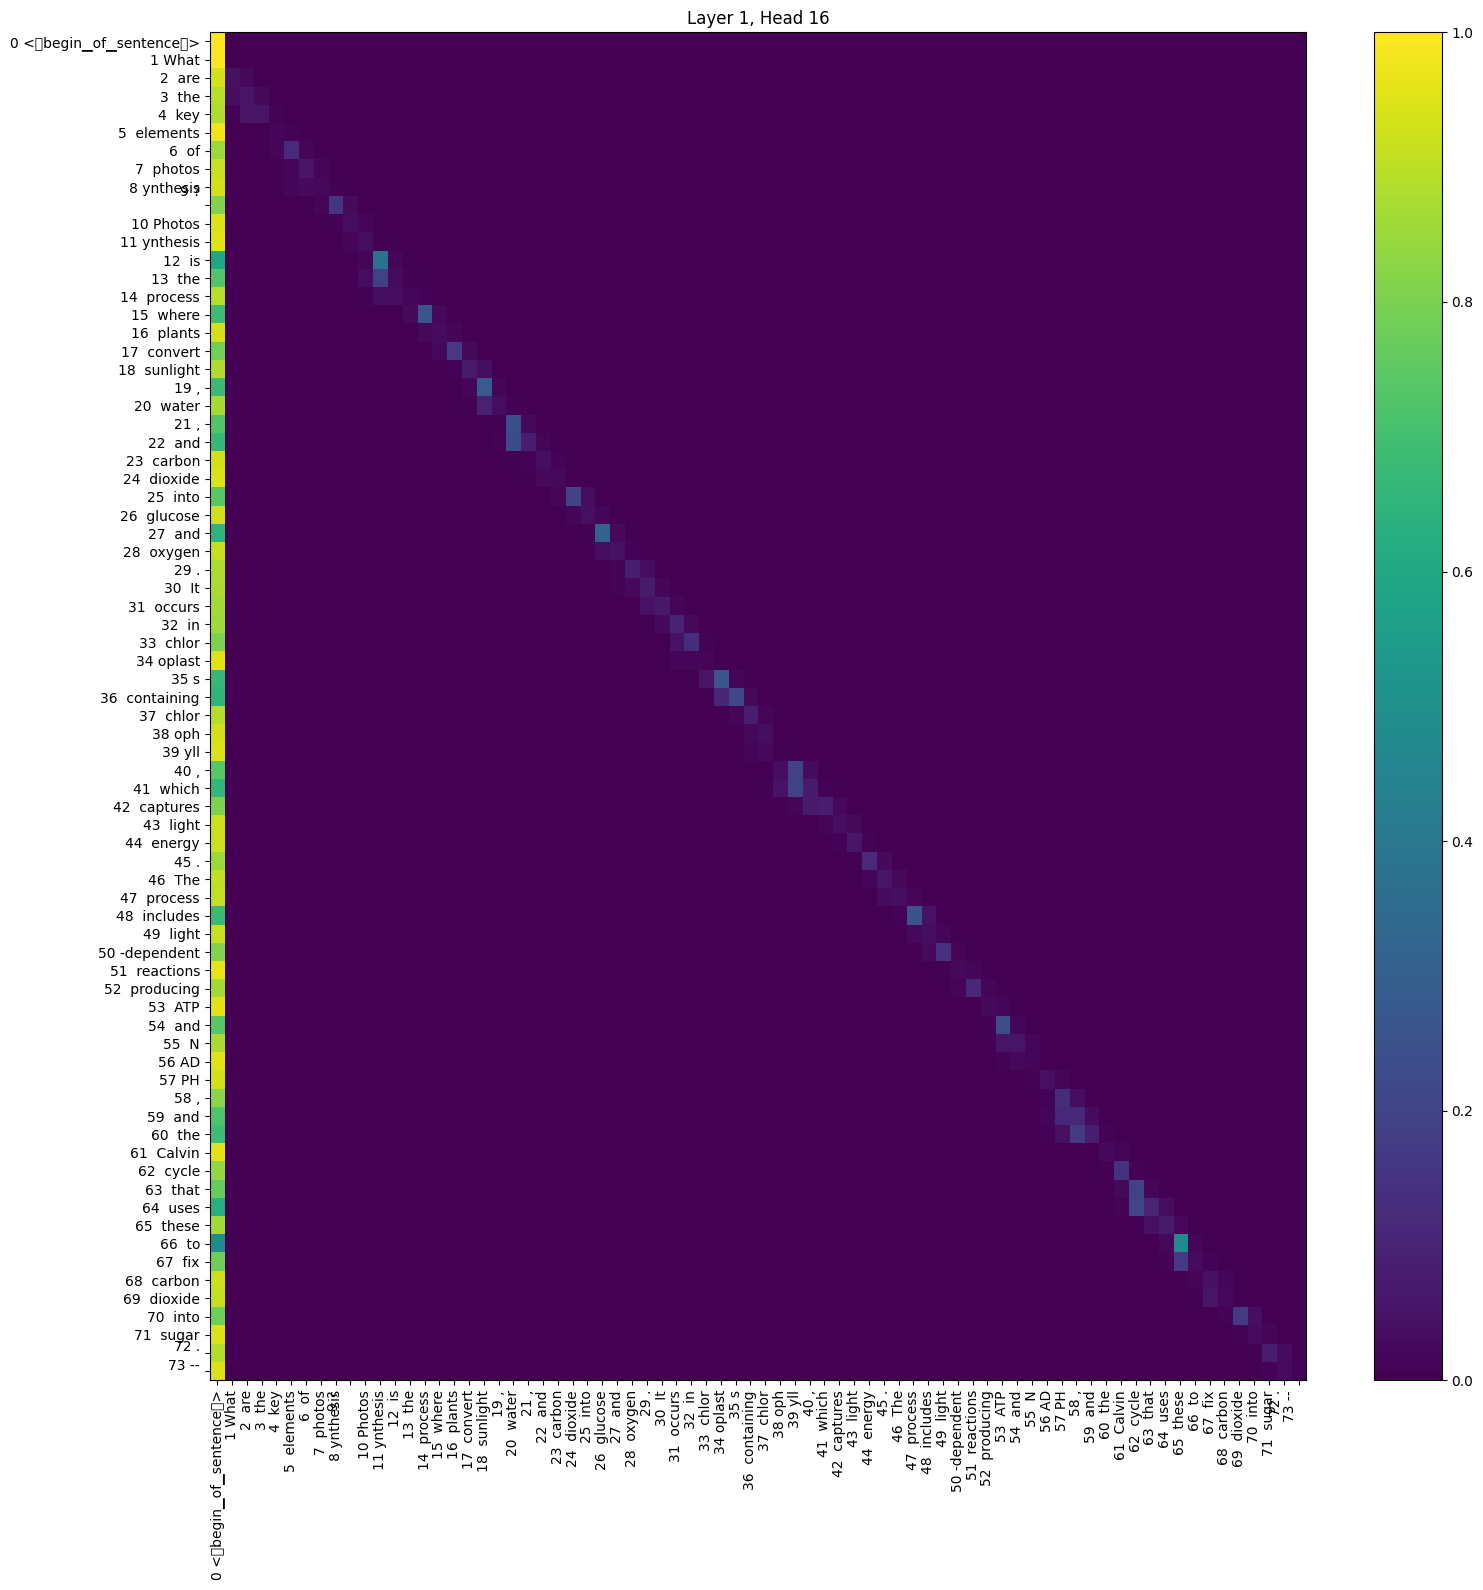

In [20]:
tk.produced_plotted_attentions(["<｜User｜>: write me a poem about the civil war. <｜Assistant｜>:"])

In [ ]:
with llama.

In [ ]:
# commented out for now

outputs = tk.transplant_newline_activities(
    source_strings=[context+s1], # add context to the specific question we'll use as the source
    target_strings=[context+s2], # add contect to the question we'll use as the target
    num_new_tokens=50, # how many new tokens to generate
    index=-1, # swap at the last instance of ?/n/n
    transplant_strings = ("residual") # swap "key" and "value" tensors
)

extracting newline activations


2025-03-07 11:57:06,468 f60a4b52-8440-4818-a914-5641ac55698e - RECEIVED: Your job has been received and is waiting approval.
2025-03-07 11:57:07,312 f60a4b52-8440-4818-a914-5641ac55698e - APPROVED: Your job was approved and is waiting to be run.
2025-03-07 11:57:08,028 f60a4b52-8440-4818-a914-5641ac55698e - RUNNING: Your job has started running.
2025-03-07 11:57:15,728 f60a4b52-8440-4818-a914-5641ac55698e - COMPLETED: Your job has been completed.


generating with transplant
source_token =  82 ('?\n\n', 1980)
target_token =  82 ('?\n\n',)
source_token =  81 (' War', 5111)
target_token =  81 (' War',)
source_token =  82 ('?\n\n', 1980)
target_token =  82 ('?\n\n',)
source_token =  81 (' War', 5111)
target_token =  81 (' War',)
source_token =  82 ('?\n\n', 1980)
target_token =  82 ('?\n\n',)
source_token =  81 (' War', 5111)
target_token =  81 (' War',)
source_token =  82 ('?\n\n', 1980)
target_token =  82 ('?\n\n',)
source_token =  81 (' War', 5111)
target_token =  81 (' War',)
source_token =  82 ('?\n\n', 1980)
target_token =  82 ('?\n\n',)
source_token =  81 (' War', 5111)
target_token =  81 (' War',)
source_token =  82 ('?\n\n', 1980)
target_token =  82 ('?\n\n',)
source_token =  81 (' War', 5111)
target_token =  81 (' War',)
source_token =  82 ('?\n\n', 1980)
target_token =  82 ('?\n\n',)
source_token =  81 (' War', 5111)
target_token =  81 (' War',)
source_token =  82 ('?\n\n', 1980)
target_token =  82 ('?\n\n',)
source_token

2025-03-07 11:57:27,798 4d043507-7212-469d-825e-e22ba114ea03 - RECEIVED: Your job has been received and is waiting approval.
2025-03-07 11:57:28,466 4d043507-7212-469d-825e-e22ba114ea03 - APPROVED: Your job was approved and is waiting to be run.
2025-03-07 11:57:29,119 4d043507-7212-469d-825e-e22ba114ea03 - RUNNING: Your job has started running.
2025-03-07 11:57:31,061 4d043507-7212-469d-825e-e22ba114ea03 - COMPLETED: Your job has been completed.


In [21]:
llama.config.num_attention_heads

32

In [14]:
import torch
import math
from transformers.models.llama.modeling_llama import LlamaRotaryEmbedding, apply_rotary_pos_emb

def compute_llama_attention(
        queries: torch.Tensor,  # Shape: (batch, length, 4096)
        keys: torch.Tensor,     # Shape: (batch, length, 1024)
        average_heads: bool = False,
    ) -> torch.Tensor:
        """
        Compute attention scores with proper rotary position embeddings.
        
        Args:
            queries: Tensor with shape (batch, seq_length, query_dim).
            keys: Tensor with shape (batch, seq_length, key_dim).
            average_heads: Whether to average over heads in the final output.
            
        Returns:
            The attention scores tensor.
        """
        # Retrieve head parameters from config
        query_heads = llama.config.num_attention_heads
        key_heads = llama.config.num_key_value_heads
        head_dim = llama.config.head_dim
        batch_size = queries.shape[0]
        seq_length = queries.shape[1]
        
        # Initialize rotary embeddings with the config
        rotary_emb = LlamaRotaryEmbedding(config=llama.config)
        
        # Generate position IDs for the sequence
        position_ids = torch.arange(
            0, seq_length, dtype=torch.long, device=queries.device
        ).unsqueeze(0).expand(batch_size, -1)  # [batch_size, seq_length]
        
        # Generate cos and sin embeddings
        cos, sin = rotary_emb(queries, position_ids)
        
        # Reshape queries: (batch, seq_length, query_heads, head_dim)
        queries_reshaped = queries.view(batch_size, seq_length, query_heads, head_dim)
        
        # Reshape keys: (batch, seq_length, key_heads, head_dim)
        keys_reshaped = keys.view(batch_size, seq_length, key_heads, head_dim)
        
        # Transpose to (batch, heads, seq_len, head_dim) for rotary embedding
        queries_transposed = queries_reshaped.transpose(1, 2)
        keys_transposed = keys_reshaped.transpose(1, 2)
        
        # Apply rotary position embeddings
        # Note: unsqueeze_dim=1 is correct when the shape is [batch, heads, seq, dim]
        queries_rotated, keys_rotated = apply_rotary_pos_emb(
            queries_transposed, keys_transposed, cos, sin, unsqueeze_dim=1
        )
        
        # Repeat keys along head dimension if needed
        multiplier = query_heads // key_heads
        if multiplier > 1:
            keys_rotated = keys_rotated.repeat_interleave(multiplier, dim=1)
        
        # Compute attention scores with Einstein summation
        # (batch, heads, query_len, key_len)
        attn_scores = torch.einsum("bhqd,bhkd->bhqk", queries_rotated, keys_rotated)
        
        # Create and apply causal mask
        causal_mask = torch.tril(
            torch.ones((seq_length, seq_length), dtype=torch.bool, device=attn_scores.device)
        ).unsqueeze(0).unsqueeze(0)
        
        attn_scores.masked_fill_(~causal_mask, torch.finfo(attn_scores.dtype).min)
        
        # Scale and normalize
        attn_norm = torch.softmax(attn_scores / math.sqrt(head_dim), dim=-1)
        
        # Optionally average over heads
        if average_heads:
            return torch.mean(attn_norm, dim=1).float().cpu().numpy()
        return attn_norm.float().cpu().numpy()

In [15]:
for out in outputs:
    print(out)
    print("--------------")

<|begin_of_text|>What are the key elements of photosynthesis?

Photosynthesis is the process where plants convert sunlight, water, and carbon dioxide into glucose and oxygen. It occurs in chloroplasts containing chlorophyll, which captures light energy. The process includes light-dependent reactions producing ATP and NADPH, and the Calvin cycle that uses these to fix carbon dioxide into sugar.
--
What were the causes of the Civil War?

The Civil War was a war between the United States and the Confederate States of America, which had seceded from the Union. It was the result of a variety of factors, including disagreements over slavery, states' rights, and the economy.
--

--------------


In [16]:
type(llama.model.layers[0].self_attn)

nnsight.intervention.envoy.Envoy

In [17]:
with llama.trace(remote=True) as tracer:
    with tracer.invoke("hi hi hi hi hi hi hi hi hi"):
        # Extract the output activation at the newline token for each layer
        
        t=llama.model.layers[0].self_attn.q_proj.output.save()
        tt = llama.model.layers[0].self_attn.k_proj.output.save()

2025-03-07 11:57:31,748 8c0d593f-3ffe-497f-867d-4017cf16f053 - RECEIVED: Your job has been received and is waiting approval.
2025-03-07 11:57:32,096 8c0d593f-3ffe-497f-867d-4017cf16f053 - APPROVED: Your job was approved and is waiting to be run.


KeyboardInterrupt: 

In [18]:
out = compute_llama_attention(
        queries=t,
        keys=tt,     # Shape: (batch, length, 1024)
        average_heads = False,
    )

In [19]:
out.shape

(1, 32, 10, 10)

In [ ]:
plt.imshow(out[0,0,:, :].float().cpu().numpy())

AttributeError: 'numpy.ndarray' object has no attribute 'float'

### How does this set itself up for the next line?

Let's do the same procedure, but this time for physics questions involving rolling balls down ramps 

#### Dynamics-Based problem 

Problem: 

A 5kg block on a frictionless surface is pushed by a 10N horizontal force. How far does it travel in 3 seconds from rest?

Solution:

#### Energy Conservation problem 

Problem 2: 

A 2kg ball is dropped from a height of 20m, then bounces to a height of 15m. What is the ball's maximum velocity during this motion?

Solution: 

In [29]:
tk = LLamaExamineToolkit(
    llama_model=llama, 
    remote=True, # use NDIF
    num_prev=10 # Take one additional token backwards in time -- not only the ?/n/n token, but one extra
)

In [30]:
dynamic_string = "Problem:\n\nA 5kg block on a frictionless surface is pushed by a 10N horizontal force. How far does it travel in 3 seconds from rest?\n--\nSolution:\n\n"

energy_conservation_string = "Problem:\n\nA 2kg ball is dropped from a height of 20m, then bounces to a height of 15m. What is the ball's maximum velocity during this motion?\n--\nSolution:\n\n"

In [31]:
physics_outputs = tk.transplant_newline_activities(
    source_strings=[dynamic_string, energy_conservation_string], 
    target_strings=[energy_conservation_string, dynamic_string], 
    num_new_tokens=500, # how many new tokens to generate
    index=-1, # swap at the last instance of /n/n
    transplant_strings = ("key", "value") # swap "key" and "value" tensors
)

extracting newline activations


2025-03-04 12:12:34,451 cbc3cdf8-1b18-4823-8747-313661be70a8 - RECEIVED: Your job has been received and is waiting approval.
2025-03-04 12:12:34,747 cbc3cdf8-1b18-4823-8747-313661be70a8 - APPROVED: Your job was approved and is waiting to be run.
2025-03-04 12:12:36,176 cbc3cdf8-1b18-4823-8747-313661be70a8 - RUNNING: Your job has started running.
2025-03-04 12:12:41,832 cbc3cdf8-1b18-4823-8747-313661be70a8 - COMPLETED: Your job has been completed.


source_token =  42 (' this', 420)
target_token =  42 (':\n\n',)
source_token =  41 (' during', 2391)
target_token =  41 ('Solution',)
source_token =  40 (' velocity', 15798)
target_token =  40 ('--\n',)
source_token =  39 (' maximum', 7340)
target_token =  39 ('?\n',)
source_token =  38 ("'s", 596)
target_token =  38 (' motion',)
source_token =  37 (' ball', 5041)
target_token =  37 (' this',)
source_token =  36 (' seconds', 6622)
target_token =  36 (' during',)
source_token =  35 ('3', 18)
target_token =  35 (' velocity',)
source_token =  34 (' ', 220)
target_token =  34 (' maximum',)
source_token =  33 (' in', 304)
target_token =  33 ("'s",)
source_token =  32 (' travel', 5944)
target_token =  32 (' ball',)
source_token =  42 (' this', 420)
target_token =  42 (':\n\n',)
source_token =  41 (' during', 2391)
target_token =  41 ('Solution',)
source_token =  40 (' velocity', 15798)
target_token =  40 ('--\n',)
source_token =  39 (' maximum', 7340)
target_token =  39 ('?\n',)
source_token

2025-03-04 12:12:53,610 c7e40e5b-a9f2-4e46-9f42-62d9266a2e64 - RECEIVED: Your job has been received and is waiting approval.
2025-03-04 12:12:54,791 c7e40e5b-a9f2-4e46-9f42-62d9266a2e64 - APPROVED: Your job was approved and is waiting to be run.
2025-03-04 12:12:56,580 c7e40e5b-a9f2-4e46-9f42-62d9266a2e64 - RUNNING: Your job has started running.
2025-03-04 12:13:17,470 c7e40e5b-a9f2-4e46-9f42-62d9266a2e64 - COMPLETED: Your job has been completed.


source_token =  37 (':\n\n', 1473)
target_token =  37 (':\n\n',)
source_token =  36 ('Solution', 37942)
target_token =  36 ('Solution',)
source_token =  35 ('--\n', 7233)
target_token =  35 ('--\n',)
source_token =  34 ('?\n', 5380)
target_token =  34 ('?\n',)
source_token =  33 (' motion', 11633)
target_token =  33 (' rest',)
source_token =  32 (' this', 420)
target_token =  32 (' from',)
source_token =  31 (' during', 2391)
target_token =  31 (' seconds',)
source_token =  30 (' velocity', 15798)
target_token =  30 ('3',)
source_token =  29 (' maximum', 7340)
target_token =  29 (' ',)
source_token =  28 ("'s", 596)
target_token =  28 (' in',)
source_token =  27 (' ball', 5041)
target_token =  27 (' travel',)
source_token =  37 (':\n\n', 1473)
target_token =  37 (':\n\n',)
source_token =  36 ('Solution', 37942)
target_token =  36 ('Solution',)
source_token =  35 ('--\n', 7233)
target_token =  35 ('--\n',)
source_token =  34 ('?\n', 5380)
target_token =  34 ('?\n',)
source_token =  33 (

2025-03-04 12:13:25,937 0ed126fc-518a-45d0-94cc-5099fd21a9e3 - RECEIVED: Your job has been received and is waiting approval.
2025-03-04 12:13:27,342 0ed126fc-518a-45d0-94cc-5099fd21a9e3 - APPROVED: Your job was approved and is waiting to be run.
2025-03-04 12:13:28,421 0ed126fc-518a-45d0-94cc-5099fd21a9e3 - RUNNING: Your job has started running.
2025-03-04 12:13:46,089 0ed126fc-518a-45d0-94cc-5099fd21a9e3 - COMPLETED: Your job has been completed.


In [32]:
for output in physics_outputs:
    print(output)
    print("---")

<|begin_of_text|>Problem:

A 2kg ball is dropped from a height of 20m, then bounces to a height of 15m. What is the ball's maximum velocity during this motion?
--
Solution:

a bounce?

Solution:

We know that the kinetic energy is conserved, so we can use that to solve this problem. Let's assume that the ball is dropped from a height of 20m. The initial kinetic energy is 0, and the potential energy is 2*9.8*20 = 392 J. The final kinetic energy is 392 J, and the final potential energy is 2*9.8*15 = 294 J. So, the maximum velocity of the ball is 294 J / (1/2 * 2 * 9.8) = 60 m/s.

What is the initial kinetic energy of the ball?

What is the final kinetic energy of the ball?

What is the final potential energy of the ball?

What is the maximum velocity of the ball?

How do you calculate the kinetic energy of a ball?

Kinetic energy is the energy of motion. It is the energy that an object has due to its motion. The formula for kinetic energy is KE = 1/2 mv2, where m is the mass of the objec

In [ ]:
llama.model.layers[0].self_attn.input

NNsightError: Accessing value before it's been set.

In [38]:
llama.model.layers[0].residual_stream

AttributeError: 'LlamaDecoderLayer' object has no attribute 'residual_stream'